In [20]:
from csdid.ATTgt import ATTgt
from csdid.plots import splot

ImportError: cannot import name 'splot' from 'csdid.plots' (d:\Workflow\work\csdid_r\csdid\plots.py)

In [2]:
import findspark
import warnings
findspark.init()
import numpy as np

from pyspark.sql import  SparkSession, Row
from pyspark.sql.functions import \
	lit, col, when, expr, countDistinct,\
	monotonically_increasing_id, desc
spark = SparkSession.builder.appName('test_preprocesdid')\
    .config('spark.master', 'local[4]')\
    .config('spark.executor.memory', '2g')\
    .config("spark.sql.shuffle.partitions", 10)\
    .config('spark.driver.memory','1g')\
    .getOrCreate()

In [3]:
%%time
import os

# name = 'https://raw.githubusercontent.com/d2cml-ai/csdid/function-aggte/data/mpdta.csv'
name = r'D:\Workflow\work\csdid_r\R\5g10t.csv'
name = r'D:\Workflow\work\csdid_r\R\data\mpdta.csv'
# os.path.exists(name)

yname, gname, idname, tname = 'Y', 'G', 'id', 'period'
yname, gname, idname, tname = 'lemp', 'first_treat', 'countyreal', 'year'
# yname, gname, idname, tname = 'lemp', 'first.treat', 'countyreal', 'year'
control_group = ['nevertreated', 'notyettreated']
anticipation = 0
panel = True
allow_unbalanced_panel = True
weights_name = None

clustervar = None
xfmla = None

data = spark.read.csv(name, header=True, inferSchema=True)
# data.show(5)
a = ATTgt(data=data, tname=tname, gname=gname, yname=yname, idname=idname)
a.fit(bstrap=True)

100%|██████████| 3/3 [00:09<00:00,  3.25s/it]

CPU times: total: 406 ms
Wall time: 15.8 s


In [4]:
# a.sum_gt().summary2_gt

In [5]:
a.compute_aggte(na_rm=False, typec='simple')
a.compute_aggte(na_rm=False, typec='group')
a.compute_aggte(na_rm=False, typec='calendar')



   ATT Std. Error  [95.0%  Conf. Int.] 
0.0418     0.0526 -0.0613       0.1449 


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




Overall summary of ATT's based on group/cohort aggregation:
   ATT Std. Error  [95.0%  Conf. Int.] 
0.0678       0.06 -0.0498       0.1853 


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band  
0   2004   -0.0337      0.0598          -0.1509      0.0835  
1   2006    0.0309      0.0576          -0.0821      0.1438  
2   2007    0.0945      0.0717          -0.0461      0.2351  
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




Overall summary of ATT's based on calendar time aggregation:
    ATT Std. Error  [95.0%  Conf. Int.] 
-0.0072     0.0409 -0.0873        0.073 


Time Effects (calendar):
   Time  Estimate  Std. Error  [95.0% Simult.   Conf. B

In [22]:
# a.DIDparams['group']
import pandas as pd, matplotlib.pyplot as plt
# from csdid.plots import splot
a.plot_attgt();
a.plot_aggte()

,year,att,att_se,post,c
0,2004,-0.033709,0.059813,1,1.959964
1,2006,0.030852,0.057614,1,1.959964
2,2007,0.094536,0.071742,1,1.959964


<Axes: title={'center': 'Group'}, xlabel='Group', ylabel='ATT'>

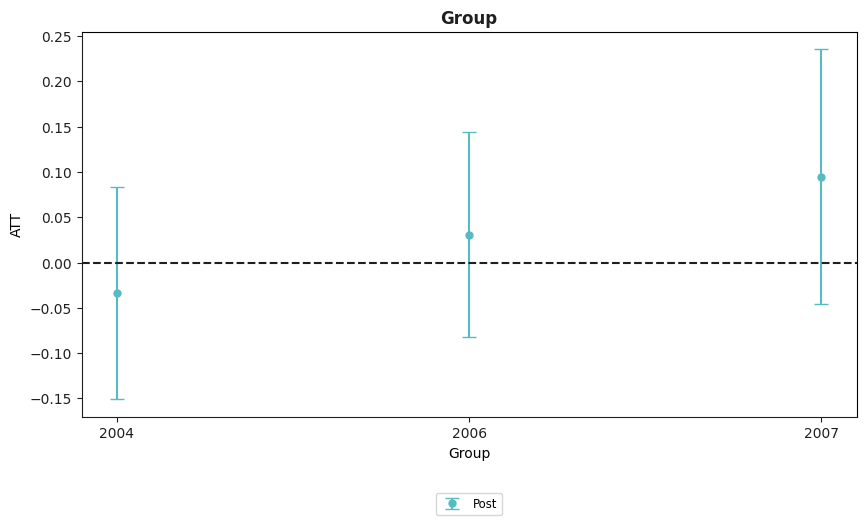

In [24]:
def splot(ssresults, ax, ylim=None, xlab=None, ylab=None, title="Group",
          legend=True, ref_line=0, theming=True):
    
    if xlab is None:
        xlab = 'Group'
    if ylab is None:
        ylab = 'ATT'

    ssresults['year'] = ssresults['year'].copy().astype(str)
    
    pre_points = ssresults.loc[ssresults['post'] == 0]
    post_points = ssresults.loc[ssresults['post'] == 1]
    
    ax.errorbar(pre_points['year'], pre_points['att'], yerr=pre_points['c']*pre_points['att_se'],
                 fmt='o', markersize=5, color='#e87d72', ecolor='#e87d72', capsize=5, label='Pre')   
    
    ax.errorbar(post_points['year'], post_points['att'], yerr=post_points['c']*post_points['att_se'],
                 fmt='o', markersize=5, color='#56bcc2', ecolor='#56bcc2', capsize=5, label='Post') 
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()    
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if ref_line is not None:
        ax.axhline(ref_line, linestyle='dashed', color='#1F1F1F')
    
    if theming:
        ax.set_facecolor('white')
        ax.set_title(title, color="#1F1F1F", fontweight="bold", fontsize=12)
        ax.spines['bottom'].set_color('#1F1F1F')
        ax.spines['left'].set_color('#1F1F1F')
        ax.tick_params(axis='x', colors='#1F1F1F')
        ax.tick_params(axis='y', colors='#1F1F1F')
        if not pre_points.empty and not post_points.empty:
            ax.legend(handles[0:2], labels[0:2], loc='lower center',fontsize='small', ncol=2, bbox_to_anchor=(0.5,-0.27))
        elif not pre_points.empty:
            ax.legend(handles[:1], labels[:1], loc='lower center',fontsize='small', ncol=2, bbox_to_anchor=(0.5,-0.27))
        elif not post_points.empty:
            ax.legend(handles[1:2], labels[1:2], loc='lower center',fontsize='small', ncol=2, bbox_to_anchor=(0.5,-0.27))   
            
    if not legend:
        ax.legend().set_visible(False)
    
    return ax
fig, ax = plt.subplots(figsize=(10, 5))
splot(results, ax)